In [1]:
import ast
import inspect
import numpy as np
import pandas as pd
import csv
from scipy import stats
import os
import datetime
import sys
import time
import random
import json
import re
import pickle
from collections import Counter
import spacy
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline

from surprise import similarities
from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise.model_selection.split import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [3]:
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [4]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/avs-fallback-comp1/code/Users/asun/Whiskeys/Recommenders'

<br>

In [5]:
'''
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html 

'''

'\nhttps://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html \n\n'

## READ FILE AND INITIAL EXPLORE

In [6]:
file_dir = '../Data_Files/' 

df_revs_rec = pd.read_csv(file_dir + 'whisk_reviews_recommender.csv')
df_revs_rec.head()

,reviewer_name,reviewer_date,alc_name,alc_type,latest_avg_rating,latest_rev_date
0,----------451,"Tasted March 2, 2021",HIGHLAND PARK 12 YEAR,single_malt_peated,3.75,2021-03-02
1,----------451,"Tasted March 12, 2021",THE POGUES IRISH WHISKEY,ireland_whiskey,2.50,2021-03-12
2,----------451,"Tasted May 12, 2021",DALMORE 12 YEAR SHERRY CASK SELECT,single_malt,4.25,2021-05-12
3,----------96,"Tasted December 29, 2017",LAPHROAIG FOUR OAK,single_malt_peated,5.00,2017-12-29
4,----------96,"Tasted January 28, 2018",NIKKA BLENDED,japan_whiskey,2.00,2018-01-28


In [7]:
# how sparse is our matrix?
# .14% of it is filled out --> 99.86% sparse
len(df_revs_rec)/(len(set(df_revs_rec['alc_name']))*len(set(df_revs_rec['reviewer_name'])))

0.0013814395866906608

In [8]:
print(len(set(df_revs_rec['reviewer_name'])))
user_review_ct = df_revs_rec.groupby(['reviewer_name']).size().reset_index(name = 'ct_reviews')

# number of users that have reviewed <5 alcohols!
user_review_ct.loc[user_review_ct['ct_reviews'] < 3].shape

25729


(17351, 2)

In [9]:
df_revs_rec['rev_ct'] = 1
df_revs_rec['rev_ct'] = df_revs_rec.groupby('reviewer_name')['rev_ct'].transform(sum)
df_revs_rec = df_revs_rec.loc[df_revs_rec['rev_ct'] >= 3] # REMOVING REVIEWERS WITH <3 REVIEWS
# df_revs_rec = df_revs_rec.drop(columns = ['rev_ct'])
print(df_revs_rec.shape)
df_revs_rec.head(10)

(89043, 7)


,reviewer_name,reviewer_date,alc_name,alc_type,latest_avg_rating,latest_rev_date,rev_ct
0,----------451,"Tasted March 2, 2021",HIGHLAND PARK 12 YEAR,single_malt_peated,3.75,2021-03-02,3
1,----------451,"Tasted March 12, 2021",THE POGUES IRISH WHISKEY,ireland_whiskey,2.50,2021-03-12,3
2,----------451,"Tasted May 12, 2021",DALMORE 12 YEAR SHERRY CASK SELECT,single_malt,4.25,2021-05-12,3
8,---------596,"Tasted July 17, 2020",GLENFIDDICH 18 YEAR,single_malt,4.00,2020-07-17,9
9,---------596,"Tasted July 30, 2020",TULLAMORE D.E.W. 12 YEAR SPECIAL RESERVE,ireland_whiskey,3.75,2020-07-30,9
10,---------596,"Tasted August 29, 2020",GLENFIDDICH FIRE & CANE,single_malt_peated,4.00,2020-08-29,9
11,---------596,"Tasted September 1, 2020",TULLAMORE D.E.W. 14 YEAR SINGLE MALT,ireland_whiskey,4.00,2020-09-01,9
12,---------596,"Tasted January 24, 2021",TULLAMORE D.E.W. XO CARIBBEAN RUM FINISH,ireland_whiskey,4.00,2021-01-24,9
13,---------596,"Tasted May 31, 2021",AERSTONE SEA CASK 10 YEAR,single_malt,4.00,2021-05-31,9
14,---------596,"Tasted September 3, 2021",TALISKER 10 YEAR,single_malt_peated,4.00,2021-09-03,9


In [10]:
# how sparse is our matrix now?
# .34% of it is filled out --> 99.66% sparse --> STILL VERY SPARSE
len(df_revs_rec)/(len(set(df_revs_rec['alc_name']))*len(set(df_revs_rec['reviewer_name'])))

0.0034152290765200326

In [11]:
# WRITE A TOP 10 TYPE OF THING
# Serendipity and novelty --> specific concepts in recommender world
# Would you discover this item on your own, or is it only through us recommending it to you? 
# A measure of serendipity --> like how popular is it? 
# Find not-so-popular distillers, not-so-popular whiskeys, a DIFFERENT whiskey from the alc_type
# Inverse Zipf dist. --> boosting things low on tail for recommending
# Slope1 collaborative filtering --> it's in Surprise

In [12]:
# How do you determine which users or items are similar to one another?
# Given that you know which users are similar, how do you determine the rating that a user would give to an item based on the ratings of similar users?
# How do you measure the accuracy of the ratings you calculate?

In [13]:
reader = Reader(rating_scale=(0, 5))

# Loads Pandas dataframe
ds_revs_rec = Dataset.load_from_df(df_revs_rec[["reviewer_name", "alc_name", "latest_avg_rating"]], reader)
print(type(ds_revs_rec))

# SET THE RANDOM SEED FOR REPRODUCIBILITY
np.random.seed(776926)

# break out
trainset, testset = train_test_split(ds_revs_rec, test_size=0.2)
print(type(trainset))
print(type(testset))

<class 'surprise.dataset.DatasetAutoFolds'>
<class 'surprise.trainset.Trainset'>
<class 'list'>


In [14]:
ls_uid = [elem[0] for elem in ds_revs_rec.raw_ratings]
ls_iid = [elem[1] for elem in ds_revs_rec.raw_ratings]
ls_rating = [elem[2] for elem in ds_revs_rec.raw_ratings]
df_surprise = pd.DataFrame({'uid': ls_uid, 'iid': ls_iid, 'rating': ls_rating})
df_surprise.head() # THIS MIRRORS the dataframe df_revs_rec above!

,uid,iid,rating
0,----------451,HIGHLAND PARK 12 YEAR,3.75
1,----------451,THE POGUES IRISH WHISKEY,2.50
2,----------451,DALMORE 12 YEAR SHERRY CASK SELECT,4.25
3,---------596,GLENFIDDICH 18 YEAR,4.00
4,---------596,TULLAMORE D.E.W. 12 YEAR SPECIAL RESERVE,3.75


In [15]:
len(trainset.build_testset()) # TO GET THE TRAINSET, YOU CAN USE BUILD_TESTSET TO GET THE RATINGS DF

71234

In [16]:
trainset_df = trainset.build_testset()
trainset_df = {'uid': [x[0] for x in trainset_df], 'iid': [x[1] for x in trainset_df], 'act': [x[2] for x in trainset_df]}
trainset_df = pd.DataFrame(trainset_df)
trainset_df.head()

,uid,iid,act
0,kstorm11,KNOB CREEK RYE SINGLE BARREL SELECT,3.75
1,kstorm11,BLADE AND BOW BOURBON,3.75
2,kstorm11,WHISTLEPIG 10 YEAR STRAIGHT RYE,4.00
3,kstorm11,OLD FORESTER 1897 BOTTLED IN BOND,3.75
4,kstorm11,LAPHROAIG LORE,5.00


In [17]:
uid_keys = trainset_df['uid'].drop_duplicates().reset_index().rename(columns={'index': 'uid_num'})
print(uid_keys.shape)
iid_keys = trainset_df['iid'].drop_duplicates().reset_index().rename(columns={'index': 'iid_num'})
print(iid_keys.shape)

trainset_df = pd.merge(trainset_df, uid_keys, "left", left_on = "uid", right_on = "uid")
trainset_df = pd.merge(trainset_df, iid_keys, "left", left_on = "iid", right_on = "iid")

(8359, 2)
(3102, 2)


In [18]:
trainset_spark = spark.createDataFrame(trainset_df.loc[:,['uid_num','iid_num','act']])

In [19]:
# trainset_spark.printSchema()
trainset_spark.show(5)

+-------+-------+----+
|uid_num|iid_num| act|
+-------+-------+----+
|      0|      0|3.75|
|      0|      1|3.75|
|      0|      2| 4.0|
|      0|      3|3.75|
|      0|      4| 5.0|
+-------+-------+----+
only showing top 5 rows



In [33]:
als = ALS(maxIter = 20, # max number of iterations -- used 25 iterations! But start with 15 and then 20
          regParam = 0.1, # regularization param
          rank = 2, # number of latent variables 
          userCol="uid_num", itemCol="iid_num", ratingCol="act", 
          coldStartStrategy="drop", nonnegative = False)

In [34]:
model = als.fit(trainset_spark)

## GET LATENT FACTORS

In [35]:
U_mtx = model.userFactors.orderBy("id").collect()
U_mtx_id = np.array([elem[0] for elem in U_mtx])
U_mtx = [elem[1] for elem in U_mtx]
U_mtx = np.array(U_mtx)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [36]:
V_mtx = model.itemFactors.orderBy("id").collect()
V_mtx_id = np.array([elem[0] for elem in V_mtx])
V_mtx = [elem[1] for elem in V_mtx]
V_mtx = np.array(V_mtx)

<br>

## GENERATING PREDICTIONS ON TEST SET

In [37]:
### MAKE TESTSET_DF AND ADD IN PREDS ###

testset_df = {'uid': [x[0] for x in testset], 'iid': [x[1] for x in testset], 
              'act': [x[2] for x in testset]}
testset_df = pd.DataFrame(testset_df)
print(testset_df.shape)

testset_df = pd.merge(testset_df, uid_keys, "inner", left_on = "uid", right_on = "uid")
testset_df = pd.merge(testset_df, iid_keys, "inner", left_on = "iid", right_on = "iid")
print(testset_df.shape)

(17809, 3)
(17733, 5)


In [38]:
testset_spark = spark.createDataFrame(testset_df.loc[:,['uid_num','iid_num','act']])

In [39]:
preds = model.transform(testset_spark).collect()

In [40]:
preds_df = pd.DataFrame({'uid_num': [elem[0] for elem in preds], 
                         'iid_num': [elem[1] for elem in preds], 
                         'est': [elem[3] for elem in preds]})
                        
testset_df = pd.merge(testset_df, preds_df, 'left', on = ['uid_num','iid_num'])
testset_df.head()

df_revs_reviewer = trainset_df.groupby(['uid']).\
    apply(lambda x: pd.Series({'rev_avg_rating': np.mean(x.act), 'rev_q75': np.quantile(x.act, 0.75), 'ct_rev': x.shape[0]})).reset_index()
df_revs_alc = trainset_df.groupby(['iid']).size().reset_index(name = 'ct_alc')
testset_df = pd.merge(testset_df, df_revs_alc, how = "left", left_on = 'iid', right_on = 'iid')
testset_df = pd.merge(testset_df, df_revs_reviewer, how = "left", left_on = 'uid', right_on = 'uid')

print('Number of ratings with negative estimated rating -- ', str(testset_df.loc[testset_df['est'] < 0].shape))
print('Number of ratings with greater than 5 rating -- ', str(testset_df.loc[testset_df['est'] > 5].shape))

testset_df.head(10)
testset_df.loc[testset_df['est'] > 5].head(10)

Number of ratings with negative estimated rating --  (22, 10)
Number of ratings with greater than 5 rating --  (138, 10)


,uid,iid,act,uid_num,iid_num,est,ct_alc,rev_avg_rating,rev_q75,ct_rev
52,WhiskeyMaster,1792 SWEET WHEAT,5.00,37800,1299,5.179436,87,4.333333,4.50,3.0
248,Per-Kristian-Thorsen,HIGHLAND PARK 18 YEAR,3.75,65922,999,5.420203,90,4.583333,4.75,3.0
480,borislaw,DAVID NICHOLSON RESERVE BOURBON,5.00,71040,348,5.258000,69,5.000000,5.00,4.0
524,worldwhiskies95,GLENGOYNE 25 YEAR,5.00,1328,8566,5.442152,8,4.858108,5.00,296.0
527,A79,GLENGOYNE 25 YEAR,5.00,67671,8566,5.340114,8,5.000000,5.00,2.0
660,LichKing,GLENGOYNE 12 YEAR,5.00,65601,127,5.370681,74,5.000000,5.00,2.0
695,Randall_Villasenor,TALISKER 8 YEAR (2018 SPECIAL RELEASE),4.75,70705,1260,5.118392,3,4.500000,4.50,1.0
918,willdrobins,TAKETSURU PURE MALT 17 YEAR,4.50,60526,1540,5.417209,38,4.583333,4.75,3.0
1333,calilife12x,PAPPY VAN WINKLE 20 YEAR,5.00,50551,778,5.215890,80,5.000000,5.00,10.0
1336,JodyCollins,PAPPY VAN WINKLE 20 YEAR,4.00,47424,778,5.897925,80,5.000000,5.00,2.0


In [41]:
# FOR > 5 RATINGS, JUST SET IT TO 5
testset_df['est'].loc[testset_df['est'] > 5] = 5

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [42]:
# BACK OUT AN ESTIMATE
print(testset_df.iloc[1])
test_uid_idx = int(uid_keys['uid_num'].loc[uid_keys['uid'] == testset_df['uid'].iloc[1]])
test_iid_idx = int(iid_keys['iid_num'].loc[iid_keys['iid'] == testset_df['iid'].iloc[1]])
uid_latent = U_mtx[np.where(U_mtx_id == test_uid_idx)[0][0], :]
iid_latent = V_mtx[np.where(V_mtx_id == test_iid_idx)[0][0], :]
 
# re-calculated estimate TO CONFIRM
sum(uid_latent*iid_latent)

uid                                magicalpoet
iid               1792 BOTTLED IN BOND BOURBON
act                                       3.75
uid_num                                  19003
iid_num                                   5198
est                                    3.67716
ct_alc                                      92
rev_avg_rating                         3.91071
rev_q75                                   4.25
ct_rev                                     168
Name: 1, dtype: object


3.6771589850211717

In [43]:
# #### SAVE THIS TESTSET_DF FOR MEASURING PERFORMANCE SEPARATELY
# file_dir = '../Data_Files/' 

# testset_df.to_csv(file_dir + 'df_preds_MFAC.csv', index = False)

<br>

## PERFORMANCE METRICS ON TEST SET

In [44]:
### DO A PLOT OF THIS WITH DIFFERENT K'S
testset_scored = testset_df # FULL TEST DF IS SCORED
testset_scored = testset_df.loc[(testset_df['ct_alc'] > 20) & (testset_df['ct_rev'] > 5), : ].reset_index(drop = True) # impossible also has actual_k = 0
testset_scored = testset_df.loc[(testset_df['act'] >= testset_df['rev_q75']) & (testset_df['ct_rev'] > 5), : ].reset_index(drop = True) # impossible also has actual_k = 0
print(testset_scored.shape)

# MSE (or RMSE) of the model
print((np.sum((testset_scored['act'] - testset_scored['est'])**2)/len(testset_scored))**(1/2))

# MAE of model
print(np.sum(np.absolute(testset_scored['act'] - testset_scored['est'])/len(testset_scored)))

(4831, 10)
0.7773529466591493
0.5869265926276594


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 62, in worker
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 525, in loads
    length = read_int(stream)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 62, in worker
  File "/anaconda/envs/azureml_py38/lib/python3.8/s

<br>

## MORE WITH LATENT FACTORS

In [59]:
file_dir = '../Data_Files/' 

df_combined_main = pd.read_csv(file_dir + 'df_whisk_main_all.csv')
df_combined_main.head()

,Whisk_Name,URL,Num_Revs,Brand,Cost,Age,ABV,Flavor,Profile,Whisk_Type,Whisk_Loc,Communal_Rating,Distiller_Score
0,STRANAHAN'S COLORADO WHISKEY,https://distiller.com/spirits/stranahan-s-colo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Single Malt,"Colorado, USA",3.70,88.0
1,BALCONES TEXAS SINGLE MALT,https://distiller.com/spirits/balcones-texas-s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Single Malt,"Texas, USA",3.99,92.0
2,WESTLAND AMERICAN OAK AMERICAN SINGLE MALT,https://distiller.com/spirits/westland-america...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Single Malt,"Washington , USA",3.74,89.0
3,CORSAIR TRIPLE SMOKE AMERICAN SINGLE MALT,https://distiller.com/spirits/corsair-triple-s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Single Malt,"Tennessee, USA",3.67,83.0
4,STRANAHAN'S DIAMOND PEAK (OLD RECIPE),https://distiller.com/spirits/stranahan-s-diam...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Single Malt,"Colorado, USA",3.88,85.0


In [60]:
df_combined_profs = pd.read_csv(file_dir + 'df_whisk_profiles_all.csv')

# set default Profile string
df_combined_profs['Profile'].loc[df_combined_profs['Profile'].isnull()] = \
    '{"smoky":-1,"peaty":-1,"spicy":-1,"herbal":-1,"oily":-1,"full_bodied":-1,"rich":-1,"sweet":-1,"briny":-1,"salty":-1,"vanilla":-1,"tart":-1,"fruity":-1,"floral":-1}'

df_combined_profs['Profile'] = [ast.literal_eval(elem) for elem in df_combined_profs['Profile']]
df_prof_split = pd.DataFrame(list(df_combined_profs['Profile']))

df_combined_profs = pd.concat([df_combined_profs, df_prof_split], axis = 1)

df_combined_profs.tail()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Whisk_Name,URL,Num_Revs,Brand,Cost,Age,ABV,Flavor,Profile,smoky,...,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
3840,STRATHISLA 12 YEAR,https://distiller.com/spirits/strathisla-12,285,Strathisla,spirit-cost cost-3,12 YEAR,40.0,FRUITY & SWEET,"{'smoky': 0, 'peaty': 0, 'spicy': 60, 'herbal'...",0,...,40,60,50,80,40,20,70,60,90,40
3841,GLEN MORAY ELGIN CLASSIC,https://distiller.com/spirits/glen-moray-classic,286,Glen Moray,spirit-cost cost-2,NAS,40.0,NaN,"{'smoky': -1, 'peaty': -1, 'spicy': -1, 'herba...",-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3842,THE MACALLAN FINE OAK 12 YEAR,https://distiller.com/spirits/the-macallan-fin...,285,The Macallan,spirit-cost cost-4,12 YEAR,40.0,NaN,"{'smoky': -1, 'peaty': -1, 'spicy': -1, 'herba...",-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3843,TOMATIN 18 YEAR OLOROSO SHERRY CASK FINISH,https://distiller.com/spirits/tomatin-18-year,288,Tomatin,spirit-cost cost-3,18 YEAR,46.0,FLORAL & FRUITY,"{'smoky': 50, 'peaty': 20, 'spicy': 60, 'herba...",50,...,20,50,50,60,0,20,30,30,60,60
3844,GLEN GARIOCH FOUNDER'S RESERVE,https://distiller.com/spirits/glen-garioch-fou...,276,Glen Garioch,spirit-cost cost-2,NaN,48.0,TART & FRUITY,"{'smoky': 20, 'peaty': 0, 'spicy': 40, 'herbal...",20,...,50,60,60,50,30,0,60,70,60,20


## ALCOHOL LATENT FACTOR MTX

In [61]:
iid_keys

,iid_num,iid
0,0,KNOB CREEK RYE SINGLE BARREL SELECT
1,1,BLADE AND BOW BOURBON
2,2,WHISTLEPIG 10 YEAR STRAIGHT RYE
3,3,OLD FORESTER 1897 BOTTLED IN BOND
4,4,LAPHROAIG LORE
...,...,...
3097,66846,CAOL ILA 2004 CASK STRENGTH (GORDON & MACPHAIL)
3098,67105,SUGAR HOUSE AMERICAN SINGLE MALT WHISKY
3099,67268,"THE BALVENIE TUN 1401, BATCH 9"
3100,68425,MONSHO PEATED PURE MALT WHISKY


In [62]:
mtx_alc_latent = pd.merge(iid_keys, df_revs_alc, how = "left", left_on = 'iid', right_on = 'iid')
mtx_alc_latent = pd.concat([mtx_alc_latent, pd.DataFrame(V_mtx, columns = ['f1', 'f2'])], axis = 1)
mtx_alc_latent.tail()
mtx_alc_latent = pd.merge(mtx_alc_latent, df_combined_main[['Whisk_Name', 'Whisk_Type', 'Distiller_Score', 'Communal_Rating']], \
                          "left", left_on = ['iid'], right_on = ['Whisk_Name'])
mtx_alc_latent = pd.merge(mtx_alc_latent, df_combined_profs, "left", left_on = ['Whisk_Name'], right_on = ['Whisk_Name'])

In [63]:
mtx_alc_latent

,iid_num,iid,ct_alc,f1,f2,Whisk_Name,Whisk_Type,Distiller_Score,Communal_Rating,URL,...,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
0,0,KNOB CREEK RYE SINGLE BARREL SELECT,29,-0.836828,1.731437,KNOB CREEK RYE SINGLE BARREL SELECT,Rye,NaN,3.93,https://distiller.com/spirits/knob-creek-rye-s...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,BLADE AND BOW BOURBON,90,-1.391568,1.277280,BLADE AND BOW BOURBON,Bourbon,90.0,3.81,https://distiller.com/spirits/blade-and-bow-bo...,...,20.0,30.0,30.0,80.0,0.0,20.0,90.0,10.0,40.0,20.0
2,2,WHISTLEPIG 10 YEAR STRAIGHT RYE,100,-0.896807,1.641228,WHISTLEPIG 10 YEAR STRAIGHT RYE,Rye,90.0,3.98,https://distiller.com/spirits/whistlepig-100-1...,...,0.0,45.0,40.0,30.0,0.0,0.0,60.0,0.0,15.0,0.0
3,3,OLD FORESTER 1897 BOTTLED IN BOND,88,-0.752188,1.698173,OLD FORESTER 1897 BOTTLED IN BOND,Bourbon,88.0,3.74,https://distiller.com/spirits/old-forester-189...,...,10.0,80.0,80.0,70.0,0.0,0.0,40.0,20.0,30.0,5.0
4,4,LAPHROAIG LORE,99,-0.778668,1.964213,LAPHROAIG LORE,Peated Single Malt,94.0,4.34,https://distiller.com/spirits/laphroaig-lore,...,20.0,80.0,80.0,50.0,60.0,30.0,20.0,10.0,40.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,66846,CAOL ILA 2004 CASK STRENGTH (GORDON & MACPHAIL),1,-1.507021,2.025349,CAOL ILA 2004 CASK STRENGTH (GORDON & MACPHAIL),Peated Single Malt,NaN,3.94,https://distiller.com/spirits/caol-ila-cask-st...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3101,67105,SUGAR HOUSE AMERICAN SINGLE MALT WHISKY,1,-1.745614,0.968338,SUGAR HOUSE AMERICAN SINGLE MALT WHISKY,American Single Malt,NaN,3.65,https://distiller.com/spirits/sugar-house-amer...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3102,67268,"THE BALVENIE TUN 1401, BATCH 9",1,-1.486274,1.626310,"THE BALVENIE TUN 1401, BATCH 9",Single Malt,90.0,4.70,https://distiller.com/spirits/the-balvenie-tun...,...,74.0,79.0,81.0,73.0,43.0,46.0,70.0,54.0,77.0,68.0
3103,68425,MONSHO PEATED PURE MALT WHISKY,1,-0.252982,1.668712,MONSHO PEATED PURE MALT WHISKY,Peated Blended Malt,NaN,4.19,https://distiller.com/spirits/monsho-peated-pu...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### SIMILARITIES OF  WHISKEY TYPES BY LATENT FACTORS

In [69]:
df_type_latent = mtx_alc_latent.groupby(['Whisk_Type']).\
    apply(lambda x: pd.Series({'f1': np.mean(x.f1), 'f2': np.mean(x.f2), 'ct': x.f2.shape[0]})).reset_index()

df_type_latent

,Whisk_Type,f1,f2,ct
0,American Single Malt,-0.827341,1.562342,100.0
1,Blended,-0.788820,1.411319,137.0
2,Blended Grain,-0.504576,1.596367,1.0
3,Blended Malt,-0.652000,1.650591,16.0
4,Bourbon,-0.997631,1.521444,993.0
5,Corn,0.237249,1.815202,1.0
6,Flavored Whiskey,-0.795005,0.947439,4.0
7,Other Whiskey,-0.536977,1.639410,23.0
8,Peated Blend,-0.780385,1.294092,3.0
9,Peated Blended Malt,-0.548287,1.852330,7.0


In [70]:
df_type_latent = df_type_latent.loc[df_type_latent['ct'] >= 5, :].reset_index(drop = True)
df_type_latent.index = df_type_latent.Whisk_Type
df_type_latent = df_type_latent.drop(columns = ['Whisk_Type', 'ct'])
print(df_type_latent.shape)

(11, 2)


In [71]:
pairwise = pd.DataFrame(
    squareform(pdist(df_type_latent)),
    columns = df_type_latent.index,
    index = df_type_latent.index)

pairwise

Whisk_Type,American Single Malt,Blended,Blended Malt,Bourbon,Other Whiskey,Peated Blended Malt,Peated Single Malt,Rye,Single Grain,Single Malt,Single Pot Still
Whisk_Type,,,,,,,,,,,
American Single Malt,0.000000,0.155858,0.196297,0.175133,0.300418,0.402448,0.275472,0.170398,0.160907,0.144509,0.154630
Blended,0.155858,0.000000,0.275628,0.236071,0.339780,0.502341,0.407818,0.235988,0.245382,0.268339,0.307805
Blended Malt,0.196297,0.275628,0.000000,0.368971,0.115566,0.226837,0.170755,0.363591,0.035493,0.087452,0.255474
Bourbon,0.175133,0.236071,0.368971,0.000000,0.475519,0.558028,0.408710,0.007079,0.334097,0.302960,0.199409
Other Whiskey,0.300418,0.339780,0.115566,0.475519,0.000000,0.213220,0.243611,0.470657,0.145715,0.202218,0.370745
Peated Blended Malt,0.402448,0.502341,0.226837,0.558028,0.213220,0.000000,0.166382,0.551584,0.257589,0.258717,0.387391
Peated Single Malt,0.275472,0.407818,0.170755,0.408710,0.243611,0.166382,0.000000,0.401892,0.180902,0.139481,0.224866
Rye,0.170398,0.235988,0.363591,0.007079,0.470657,0.551584,0.401892,0.000000,0.328808,0.296872,0.192331
Single Grain,0.160907,0.245382,0.035493,0.334097,0.145715,0.257589,0.180902,0.328808,0.000000,0.068074,0.229941


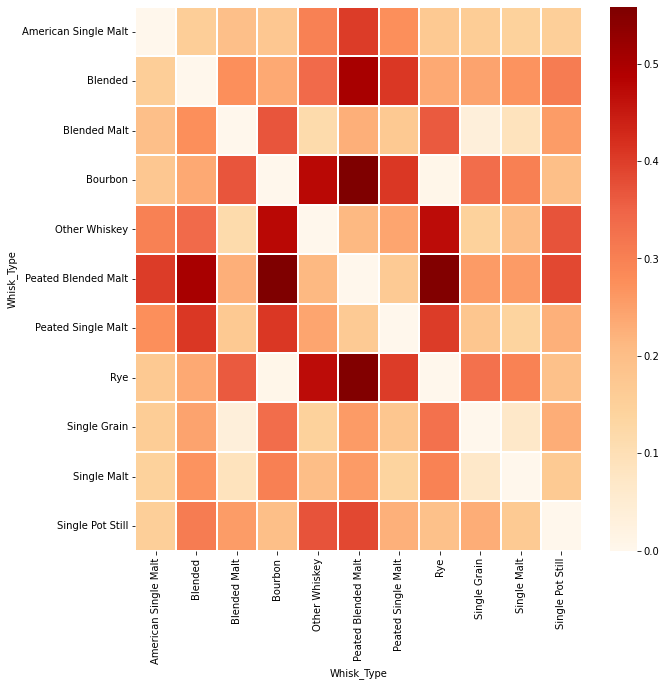

In [72]:
plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise,
    cmap='OrRd',
    linewidth=1
)

### SIMILARITY OF DISTILLERIES BY LATENT FACTORS

In [103]:
df_distiller_latent = mtx_alc_latent.groupby(['Brand']).\
    apply(lambda x: pd.Series({'f1': np.mean(x.f1), 'f2': np.mean(x.f2), 'ct': x.f2.shape[0]})).reset_index()

# CAN'T PLOT ALL OF THEM
df_distiller_latent.shape 

(629, 4)

In [104]:
# TAKE A SUBSET OF DISTILLERIES TO PLOT TOGETHER
df_distiller_latent = df_distiller_latent.loc[(df_distiller_latent['ct'] >= 10) & (df_distiller_latent['ct'] <= 20), :].reset_index(drop = True)
df_distiller_latent.index = df_distiller_latent.Brand
df_distiller_latent = df_distiller_latent.drop(columns = ['Brand', 'ct'])
print(df_distiller_latent.shape)
df_distiller_latent.head(10)

(42, 2)


,f1,f2
Brand,,
Aberlour,-0.513354,1.817134
Amrut,-0.806558,1.807558
Angel's Envy,-0.996355,1.723426
Arran,-0.621276,1.753404
Auchentoshan,-0.797111,1.583387
Balblair,-0.588796,1.919752
Balcones,-0.669728,1.798023
Bardstown Bourbon Co.,-1.209977,1.570039
Barton 1792,-0.987338,1.456640


In [106]:
pairwise = pd.DataFrame(
    squareform(pdist(df_distiller_latent)),
    columns = df_distiller_latent.index,
    index = df_distiller_latent.index)

pairwise

Brand,Aberlour,Amrut,Angel's Envy,Arran,Auchentoshan,Balblair,Balcones,Bardstown Bourbon Co.,Barton 1792,Benromach,...,Suntory,Talisker,Teeling,The Dalmore,The Glenrothes,The Singleton,Tomatin,Tullamore D.E.W.,Westland,anCnoc
Brand,,,,,,,,,,,,,,,,,,,,,
Aberlour,0.000000,0.293361,0.492007,0.125334,0.367636,0.127366,0.157538,0.739148,0.595497,0.290976,...,0.551933,0.357818,0.452041,0.320287,0.148965,0.229983,0.118061,0.453155,0.345564,0.144291
Amrut,0.293361,0.000000,0.207607,0.193034,0.224369,0.244965,0.137162,0.468147,0.394746,0.109012,...,0.284184,0.092706,0.247733,0.041130,0.276774,0.420082,0.385418,0.284538,0.053869,0.154655
Angel's Envy,0.492007,0.207607,0.000000,0.376275,0.243534,0.452380,0.335037,0.262987,0.266938,0.216983,...,0.092407,0.202983,0.177848,0.173231,0.436145,0.568045,0.568582,0.236176,0.168150,0.347893
Arran,0.125334,0.193034,0.376275,0.000000,0.244589,0.169489,0.065867,0.616597,0.471243,0.167366,...,0.430037,0.274836,0.326773,0.210528,0.096580,0.236801,0.194183,0.329937,0.246859,0.044470
Auchentoshan,0.367636,0.224369,0.243534,0.244589,0.000000,0.395647,0.249589,0.413082,0.228585,0.119495,...,0.245593,0.303353,0.099183,0.193860,0.252232,0.355195,0.399378,0.085520,0.244823,0.246412
Balblair,0.127366,0.244965,0.452380,0.169489,0.395647,0.000000,0.146178,0.712857,0.610989,0.290301,...,0.527573,0.280013,0.460644,0.282318,0.244554,0.353175,0.244486,0.477551,0.287839,0.150671
Balcones,0.157538,0.137162,0.335037,0.065867,0.249589,0.146178,0.000000,0.586384,0.466281,0.146753,...,0.398990,0.212089,0.316659,0.162773,0.161845,0.302643,0.249733,0.331435,0.190480,0.021401
Bardstown Bourbon Co.,0.739148,0.468147,0.262987,0.616597,0.413082,0.712857,0.586384,0.000000,0.249855,0.449248,...,0.187433,0.462410,0.313986,0.430729,0.655958,0.768267,0.799419,0.349631,0.431133,0.595896
Barton 1792,0.595497,0.394746,0.266938,0.471243,0.228585,0.610989,0.466281,0.249855,0.000000,0.320719,...,0.189729,0.439362,0.150705,0.354155,0.478194,0.563241,0.625158,0.143845,0.385658,0.467245


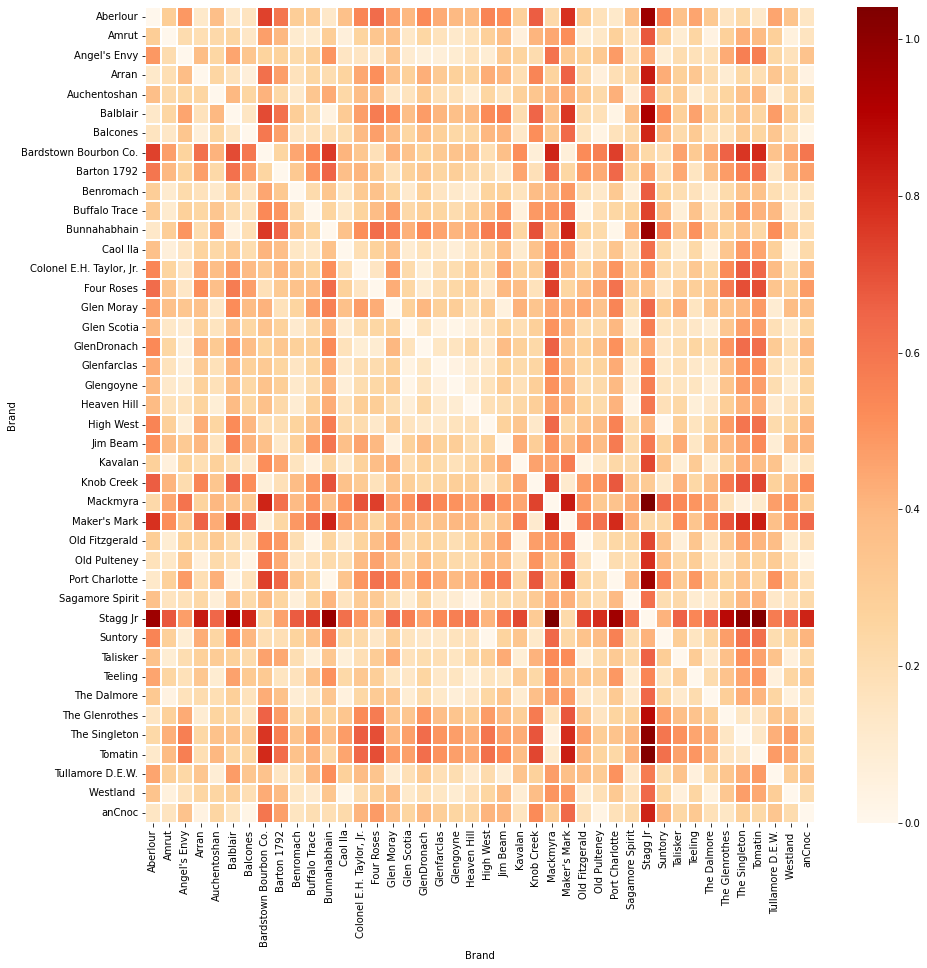

In [107]:
plt.figure(figsize=(15,15))
sns.heatmap(
    pairwise,
    cmap='OrRd',
    linewidth=1
)

### SIMILARITY OF ALCOHOLS BY LATENT FACTORS

In [108]:
print(mtx_alc_latent.shape)
mtx_alc_latent.head()

(3105, 31)


,iid_num,iid,ct_alc,f1,f2,Whisk_Name,Whisk_Type,Distiller_Score,Communal_Rating,URL,...,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
0,0,KNOB CREEK RYE SINGLE BARREL SELECT,29,-0.836828,1.731437,KNOB CREEK RYE SINGLE BARREL SELECT,Rye,NaN,3.93,https://distiller.com/spirits/knob-creek-rye-s...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,BLADE AND BOW BOURBON,90,-1.391568,1.277280,BLADE AND BOW BOURBON,Bourbon,90.0,3.81,https://distiller.com/spirits/blade-and-bow-bo...,...,20.0,30.0,30.0,80.0,0.0,20.0,90.0,10.0,40.0,20.0
2,2,WHISTLEPIG 10 YEAR STRAIGHT RYE,100,-0.896807,1.641228,WHISTLEPIG 10 YEAR STRAIGHT RYE,Rye,90.0,3.98,https://distiller.com/spirits/whistlepig-100-1...,...,0.0,45.0,40.0,30.0,0.0,0.0,60.0,0.0,15.0,0.0
3,3,OLD FORESTER 1897 BOTTLED IN BOND,88,-0.752188,1.698173,OLD FORESTER 1897 BOTTLED IN BOND,Bourbon,88.0,3.74,https://distiller.com/spirits/old-forester-189...,...,10.0,80.0,80.0,70.0,0.0,0.0,40.0,20.0,30.0,5.0
4,4,LAPHROAIG LORE,99,-0.778668,1.964213,LAPHROAIG LORE,Peated Single Malt,94.0,4.34,https://distiller.com/spirits/laphroaig-lore,...,20.0,80.0,80.0,50.0,60.0,30.0,20.0,10.0,40.0,15.0


Text(0, 0.5, 'F2')

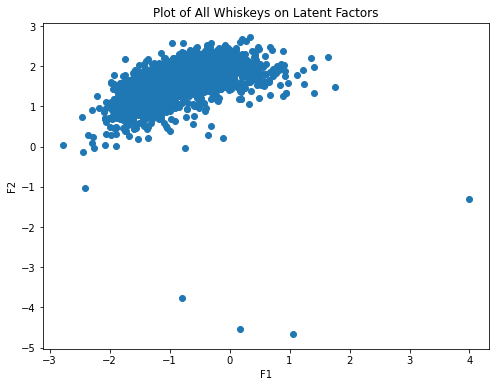

Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 62, in worker
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 525, in loads
    length = read_int(stream)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 62, in worker
  File "/anaconda/envs/azureml_py38/lib/python3.8/s

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(mtx_alc_latent['f1'], mtx_alc_latent['f2'])
plt.title('Plot of All Whiskeys on Latent Factors')
plt.xlabel('F1')
plt.ylabel('F2')

In [81]:
mtx_alc_latent.loc[(mtx_alc_latent['f1'] <= -.5) | (mtx_alc_latent['f2'] <= -3), :]

,iid_num,iid,ct_alc,f1,f2,Whisk_Name,Whisk_Type,Distiller_Score,Communal_Rating,URL,...,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
1400,2315,WESTLAND GARRYANA 2017 EDITION 2|1,7,-0.748756,4.935021,WESTLAND GARRYANA 2017 EDITION 2|1,American Single Malt,92.0,4.69,https://distiller.com/spirits/westland-garryan...,...,20.0,80.0,70.0,70.0,0.0,10.0,80.0,50.0,60.0,0.0
2252,7317,THE BALVENIE TUN 1509 BATCH 1,6,-1.181790,3.837976,THE BALVENIE TUN 1509 BATCH 1,Single Malt,98.0,4.63,https://distiller.com/spirits/the-balvenie-tun...,...,15.0,80.0,80.0,80.0,0.0,10.0,40.0,0.0,40.0,20.0
2547,12076,KNAPPOGUE CASTLE 1990,3,-2.182603,-4.012418,KNAPPOGUE CASTLE 1990,Single Malt,NaN,3.10,https://distiller.com/spirits/knappogue-castle...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2608,13714,FIDDLER GEORGIA HEARTWOOD BOURBON,6,-0.225940,-4.087831,FIDDLER GEORGIA HEARTWOOD BOURBON,Bourbon,NaN,3.79,https://distiller.com/spirits/fiddler-georgia-...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2801,19590,JOHN L SULLIVAN IRISH WHISKEY,3,-4.535428,1.509830,JOHN L SULLIVAN IRISH WHISKEY,Blended,77.0,3.77,https://distiller.com/spirits/john-l-sullivan-...,...,20.0,20.0,15.0,20.0,0.0,0.0,20.0,15.0,20.0,10.0
3067,47474,GRANGESTONE 25YR SINGLE MALT SHERRY CASK FINISH,4,-0.550059,-3.653142,GRANGESTONE 25YR SINGLE MALT SHERRY CASK FINISH,Single Malt,NaN,4.25,https://distiller.com/spirits/grangestone-25yr...,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [87]:
# GET RID OF ALCS WITH <5 REVIEWS AND THE OUTLIERS?

mtx_alc_reduced = mtx_alc_latent.loc[mtx_alc_latent['ct_alc'] >= 5].reset_index(drop = True).drop(columns = 'iid')
mtx_alc_reduced = mtx_alc_reduced.loc[(mtx_alc_reduced['f1'] >= -.5) & (mtx_alc_reduced['f2'] >= -3), :].reset_index(drop = True)

mtx_alc_reduced.shape

(2517, 30)

Text(0, 0.5, 'F2')

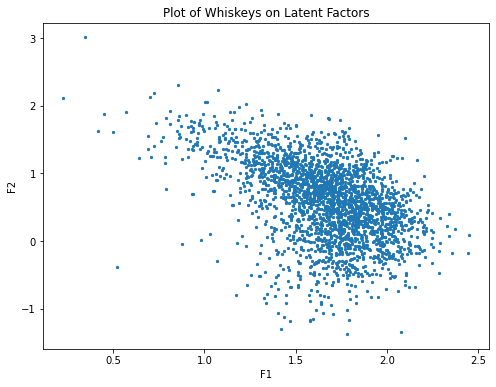

In [89]:
plt.figure(figsize=(8, 6))
plt.scatter(mtx_alc_reduced['f1'].loc[mtx_alc_reduced['f1']>-.5], 
            mtx_alc_reduced['f2'].loc[mtx_alc_reduced['f1']>-.5], s = 5)
plt.title('Plot of Whiskeys on Latent Factors')
plt.xlabel('F1')
plt.ylabel('F2')

In [92]:
mtx_alc_reduced.loc[(mtx_alc_reduced['f1'] <= 0.5) & (mtx_alc_reduced['f2'] >= 1.5),\
                   ['Whisk_Name', 'Whisk_Type', 'ct_alc', 'f1', 'f2', 'Brand', 'Flavor', 'Profile', \
                   'smoky', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'vanilla', 'tart', 'fruity', 'floral']]

,Whisk_Name,Whisk_Type,ct_alc,f1,f2,Brand,Flavor,Profile,smoky,spicy,herbal,oily,full_bodied,rich,sweet,briny,vanilla,tart,fruity,floral
119,KNAPPOGUE CASTLE 14 YEAR TWIN WOOD,Single Malt,17,0.345909,3.009294,Knappogue Castle,RICH & FULL BODIED,"{'smoky': 30, 'peaty': 0, 'spicy': 20, 'herbal...",30.0,20.0,40.0,30.0,80.0,80.0,70.0,0.0,70.0,30.0,70.0,40.0
1478,CRAIGELLACHIE 19 YEAR,Single Malt,6,0.226071,2.115372,Craigellachie,SPICY,"{'smoky': 20, 'peaty': 5, 'spicy': 65, 'herbal...",20.0,65.0,50.0,20.0,40.0,40.0,50.0,5.0,35.0,25.0,50.0,15.0
1648,ARRAN 16 YEAR,Single Malt,6,0.451787,1.879836,Arran,TART & VANILLA,"{'smoky': 40, 'peaty': 0, 'spicy': 50, 'herbal...",40.0,50.0,30.0,0.0,60.0,40.0,70.0,50.0,70.0,70.0,60.0,60.0
2303,WINCHESTER STRAIGHT BOURBON,Bourbon,9,0.497470,1.614655,Winchester,NaN,"{'smoky': -1, 'peaty': -1, 'spicy': -1, 'herba...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2343,BEN BRACKEN SPEYSIDE SINGLE MALT,Single Malt,7,0.414315,1.626587,NaN,NaN,"{'smoky': -1, 'peaty': -1, 'spicy': -1, 'herba...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [99]:
mtx_alc_reduced.loc[(mtx_alc_reduced['f2'] <= -1.25), \
                    ['Whisk_Name', 'Whisk_Type', 'ct_alc', 'f1', 'f2', 'Brand', 'Flavor', 'Profile', \
                     'smoky', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'vanilla', 'tart', 'fruity', 'floral']]

,Whisk_Name,Whisk_Type,ct_alc,f1,f2,Brand,Flavor,Profile,smoky,spicy,herbal,oily,full_bodied,rich,sweet,briny,vanilla,tart,fruity,floral
386,JEPTHA CREED FOUR GRAIN STRAIGHT BOURBON,Bourbon,19,1.422625,-1.305119,Jeptha Creed,NaN,"{'smoky': -1, 'peaty': -1, 'spicy': -1, 'herba...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1990,ROUGHSTOCK MONTANA BOURBON WHISKEY,Bourbon,6,1.781841,-1.375588,RoughtStock,NaN,"{'smoky': -1, 'peaty': -1, 'spicy': -1, 'herba...",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2219,RANGER CREEK RIMFIRE MESQUITE SMOKED TEXAS SIN...,American Single Malt,9,2.080065,-1.353765,Ranger Creek,SPICY & SMOKY,"{'smoky': 55, 'peaty': 0, 'spicy': 60, 'herbal...",55.0,60.0,40.0,30.0,45.0,45.0,50.0,0.0,45.0,30.0,25.0,0.0


In [100]:
# FILTER ON ALCS WITH DISTILLER.COM FLAVORS + PROFILES
mtx_alc_reduced2 = mtx_alc_reduced.loc[~mtx_alc_reduced['Flavor'].isnull(),:].reset_index(drop = True)
mtx_alc_reduced2.shape

(1605, 30)

Text(0, 0.5, 'F2')

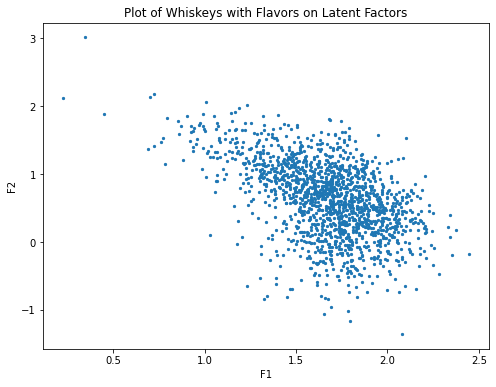

In [103]:
plt.figure(figsize=(8, 6))
plt.scatter(mtx_alc_reduced2['f1'].loc[mtx_alc_reduced2['f1']>-4], mtx_alc_reduced2['f2'].loc[mtx_alc_reduced2['f1']>-4], s = 5)
plt.title('Plot of Whiskeys with Flavors on Latent Factors')
plt.xlabel('F1')
plt.ylabel('F2')

In [104]:
mtx_alc_reduced2.columns

Index(['iid_num', 'ct_alc', 'f1', 'f2', 'Whisk_Name', 'Whisk_Type',
       'Distiller_Score', 'Communal_Rating', 'URL', 'Num_Revs', 'Brand',
       'Cost', 'Age', 'ABV', 'Flavor', 'Profile', 'smoky', 'peaty', 'spicy',
       'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'salty',
       'vanilla', 'tart', 'fruity', 'floral'],
      dtype='object')

In [105]:
mtx_alc_reduced2.loc[(mtx_alc_reduced2['f1'] <= 0.5) & (mtx_alc_reduced2['f2'] >= 1.5), \
                     ['Whisk_Name', 'Whisk_Type', 'Brand', 'Flavor', 'smoky', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'vanilla', 'tart', 'fruity', 'floral']]

,Whisk_Name,Whisk_Type,Brand,Flavor,smoky,spicy,herbal,oily,full_bodied,rich,sweet,briny,vanilla,tart,fruity,floral
102,KNAPPOGUE CASTLE 14 YEAR TWIN WOOD,Single Malt,Knappogue Castle,RICH & FULL BODIED,30.0,20.0,40.0,30.0,80.0,80.0,70.0,0.0,70.0,30.0,70.0,40.0
1077,CRAIGELLACHIE 19 YEAR,Single Malt,Craigellachie,SPICY,20.0,65.0,50.0,20.0,40.0,40.0,50.0,5.0,35.0,25.0,50.0,15.0
1172,ARRAN 16 YEAR,Single Malt,Arran,TART & VANILLA,40.0,50.0,30.0,0.0,60.0,40.0,70.0,50.0,70.0,70.0,60.0,60.0


In [106]:
mtx_alc_reduced2.loc[(mtx_alc_reduced2['f1'] >= 2.0) & (mtx_alc_reduced2['f2'] <= 0.25), \
                     ['Whisk_Name', 'Whisk_Type', 'Brand', 'Flavor', 'smoky', 'spicy', 'herbal', 'oily', 'full_bodied', 'rich', 'sweet', 'briny', 'vanilla', 'tart', 'fruity', 'floral']]

,Whisk_Name,Whisk_Type,Brand,Flavor,smoky,spicy,herbal,oily,full_bodied,rich,sweet,briny,vanilla,tart,fruity,floral
28,WYOMING WHISKEY DOUBLE CASK,Bourbon,Wyoming Whiskey,SWEET & RICH,20.0,50.0,30.0,40.0,80.0,80.0,80.0,0.0,60.0,40.0,60.0,0.0
82,BOOKER’S BOURBON BATCH 2016-01 “BOOKER’S BLUEG...,Bourbon,Booker's,FULL BODIED & RICH,15.0,60.0,0.0,40.0,70.0,60.0,30.0,5.0,40.0,0.0,15.0,0.0
138,WILLIAM LARUE WELLER BOURBON (FALL 2018),Bourbon,William Larue Weller,SPICY,35.0,55.0,20.0,10.0,40.0,40.0,45.0,0.0,25.0,30.0,25.0,0.0
168,GLENFARCLAS 40 YEAR,Single Malt,Glenfarclas,RICH & FULL BODIED,30.0,40.0,30.0,40.0,90.0,90.0,80.0,0.0,50.0,50.0,80.0,40.0
169,WILD TURKEY MASTER'S KEEP CORNERSTONE RYE,Rye,Wild Turkey,TART & FRUITY,30.0,30.0,25.0,15.0,45.0,45.0,30.0,0.0,30.0,65.0,55.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,BOOKER’S BOURBON BATCH 2021-04 “NOE STRANGERS ...,Bourbon,Booker's,SWEET & SPICY,5.0,75.0,8.0,10.0,65.0,65.0,80.0,0.0,20.0,8.0,35.0,0.0
1539,OLD FITZGERALD BOTTLED IN BOND 8 YEAR (SPRING ...,Bourbon,Old Fitzgerald,FULL BODIED & RICH,5.0,20.0,10.0,10.0,85.0,80.0,70.0,0.0,30.0,15.0,20.0,0.0
1540,WILLIAM LARUE WELLER BOURBON (FALL 2021),Bourbon,William Larue Weller,SWEET & SPICY,10.0,55.0,5.0,10.0,50.0,50.0,60.0,0.0,15.0,25.0,30.0,0.0
1567,SONOMA COUNTY DISTILLING CO. CHERRYWOOD RYE WH...,Rye,Sonoma County Distilling Company,RICH & FULL BODIED,20.0,30.0,20.0,10.0,70.0,70.0,50.0,0.0,40.0,10.0,30.0,10.0


In [111]:
mtx_alc_reduced2['grp'] = 1
mtx_alc_reduced2.loc[(mtx_alc_reduced2['f1'] <= 1.00) & (mtx_alc_reduced2['f2'] >= 1.5), :].\
    groupby(['grp']).\
    apply(lambda x: pd.Series({'smoky': np.mean(x.smoky), 'peaty': np.mean(x.peaty), 'spicy': np.mean(x.spicy), 
                              'herbal': np.mean(x.herbal), 'oily': np.mean(x.oily), 'full_bodied': np.mean(x.full_bodied), 
                              'rich': np.mean(x.rich), 'sweet': np.mean(x.sweet), 'briny': np.mean(x.briny), 
                              'salty': np.mean(x.salty), 'vanilla': np.mean(x.vanilla), 'tart': np.mean(x.tart), 
                              'fruity': np.mean(x.fruity), 'floral': np.mean(x.floral)})).reset_index()

,grp,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
0,1,37.272727,25.409091,46.090909,31.727273,28.818182,56.727273,54.136364,54.454545,18.545455,16.727273,44.909091,27.636364,50.636364,29.454545


In [110]:
mtx_alc_reduced2['grp'] = 1
mtx_alc_reduced2.loc[(mtx_alc_reduced2['f1'] >= 2.0) & (mtx_alc_reduced2['f2'] <= 0), :]. \
    groupby(['grp']).\
    apply(lambda x: pd.Series({'smoky': np.mean(x.smoky), 'peaty': np.mean(x.peaty), 'spicy': np.mean(x.spicy), 
                              'herbal': np.mean(x.herbal), 'oily': np.mean(x.oily), 'full_bodied': np.mean(x.full_bodied), 
                              'rich': np.mean(x.rich), 'sweet': np.mean(x.sweet), 'briny': np.mean(x.briny), 
                              'salty': np.mean(x.salty), 'vanilla': np.mean(x.vanilla), 'tart': np.mean(x.tart), 
                              'fruity': np.mean(x.fruity), 'floral': np.mean(x.floral)})).reset_index()

,grp,smoky,peaty,spicy,herbal,oily,full_bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral
0,1,20.675676,0.135135,55.540541,27.243243,34.189189,61.756757,59.72973,58.513514,3.513514,4.0,51.756757,25.351351,41.621622,20.540541


### HOW MUCH VARIANCE IS EXPLAINED BY EACH FACTOR?

In [ ]:
# HOW MUCH VARIANCE IS EXPLAINED BY EACH FACTOR